# Présentation Partie 5 - Mesure de performance et suivi de production

## Objectif : Dashboard temps réel et détection de drift

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("PARTIE 5: MESURE PERFORMANCE & SUIVI PRODUCTION")
print("=" * 50)

PARTIE 5: MESURE PERFORMANCE & SUIVI PRODUCTION


## 1. Chargement du modèle et données de test

In [14]:
# Chargement des données
df = pd.read_csv('../data/raw/creditcard.csv')

# Feature engineering
df['Hour'] = (df['Time'] / 3600) % 24
df['Day'] = df['Time'] // 86400
df['Is_Night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)
df['Is_Weekend'] = (df['Day'] % 7 >= 5).astype(int)
df['Amount_log'] = np.log1p(df['Amount'])

# Création d'Amount_Category avec encodage numérique
df['Amount_Category'] = 0  # Par défaut Micro (0-10€)
df.loc[(df['Amount'] > 10) & (df['Amount'] <= 50), 'Amount_Category'] = 1   # Small
df.loc[(df['Amount'] > 50) & (df['Amount'] <= 200), 'Amount_Category'] = 2  # Medium  
df.loc[df['Amount'] > 200, 'Amount_Category'] = 3  # Large

# Variables PCA enrichies
pca_cols = [f'V{i}' for i in range(1, 29)]
df['PCA_Magnitude'] = np.sqrt((df[pca_cols]**2).sum(axis=1))
df['PCA_Extreme_Count'] = (np.abs(df[pca_cols]) > 3).sum(axis=1)

# Sélection des features
feature_cols = pca_cols + ['Amount', 'Amount_log', 'Hour', 'Day', 'Is_Night', 'Is_Weekend', 
                          'PCA_Magnitude', 'PCA_Extreme_Count', 'Amount_Category']
X = df[feature_cols]
y = df['Class']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Entraînement du modèle Random Forest (meilleur modèle de la partie 4)
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

print(f" Modèle entraîné sur {len(X_train):,} échantillons")
print(f" Test set: {len(X_test):,} échantillons")
print(f" Features: {len(feature_cols)}")

 Modèle entraîné sur 199,364 échantillons
 Test set: 85,443 échantillons
 Features: 37


## 2. Métriques Prometheus pour Dashboard

In [15]:
# Métriques Prometheus pour les 3 indicateurs demandés
from prometheus_client import CollectorRegistry, Gauge, Counter

# Créer un nouveau registre pour éviter les conflits
registry = CollectorRegistry()

# Métriques pour les 3 indicateurs demandés
detection_rate = Gauge('fraud_detection_rate', 'Taux de détection des fraudes', registry=registry)
false_positive_rate = Gauge('fraud_false_positive_rate', 'Taux de faux positifs', registry=registry)
data_drift_score = Gauge('fraud_data_drift_score', 'Score de dérive des données', registry=registry)

# Métriques additionnelles pour monitoring
total_predictions = Counter('fraud_total_predictions', 'Nombre total de prédictions', registry=registry)
fraud_detected = Counter('fraud_detected_total', 'Nombre de fraudes détectées', registry=registry)
false_positives = Counter('fraud_false_positives_total', 'Nombre de faux positifs', registry=registry)

print("Métriques Prometheus configurées")
print("   detection_rate: Taux de détection")
print("   false_positive_rate: Taux de faux positifs")
print("   data_drift_score: Score de dérive")

Métriques Prometheus configurées
   detection_rate: Taux de détection
   false_positive_rate: Taux de faux positifs
   data_drift_score: Score de dérive


## 3. Simulation de données de production et calcul des métriques

In [16]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calcule les métriques pour le dashboard"""
    
    # 1. Taux de détection (Recall)
    detection = recall_score(y_true, y_pred)
    
    # 2. Taux de faux positifs
    fp = sum((y_pred == 1) & (y_true == 0))
    tn = sum((y_pred == 0) & (y_true == 0))
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    return {
        'detection_rate': detection,
        'false_positive_rate': fp_rate,
        'precision': precision_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

def detect_data_drift(baseline_data, current_data):
    """Détection simple de dérive basée sur les distributions"""
    from scipy.stats import ks_2samp
    
    # Test de Kolmogorov-Smirnov sur quelques features clés
    key_features = ['Amount', 'Hour', 'PCA_Magnitude']
    drift_scores = []
    
    for feature in key_features:
        if feature in baseline_data.columns and feature in current_data.columns:
            statistic, p_value = ks_2samp(baseline_data[feature], current_data[feature])
            # Score de drift : plus p_value est faible, plus il y a drift
            drift_score = 1 - p_value if p_value < 1 else 0
            drift_scores.append(drift_score)
    
    return np.mean(drift_scores) if drift_scores else 0

# Simulation de données en production avec dérive progressive
def simulate_production_monitoring(model, X_baseline, X_test, y_test, periods=10):
    """Simule le monitoring en production avec dérive progressive"""
    
    results = []
    
    # Période de référence (baseline)
    baseline_size = len(X_baseline) // 4
    X_baseline_sample = X_baseline.iloc[:baseline_size]
    
    for period in range(periods):
        # Simulation d'une dérive progressive
        drift_factor = period * 0.1  # Dérive progressive
        
        # Échantillon de test avec bruit ajouté pour simuler la dérive
        start_idx = period * 1000
        end_idx = min(start_idx + 1000, len(X_test))
        
        if start_idx >= len(X_test):
            break
            
        X_current = X_test.iloc[start_idx:end_idx].copy()
        y_current = y_test.iloc[start_idx:end_idx]
        
        # Ajout de bruit pour simuler la dérive sur certaines features
        if drift_factor > 0:
            noise_features = ['Amount', 'Hour']
            for feature in noise_features:
                if feature in X_current.columns:
                    noise = np.random.normal(0, drift_factor * X_current[feature].std(), len(X_current))
                    X_current[feature] += noise
        
        # Prédictions
        y_pred = model.predict(X_current)
        y_pred_proba = model.predict_proba(X_current)[:, 1]
        
        # Calcul des métriques
        metrics = calculate_metrics(y_current, y_pred, y_pred_proba)
        
        # Détection de dérive
        drift_score = detect_data_drift(X_baseline_sample, X_current)
        
        result = {
            'period': period + 1,
            'timestamp': datetime.now() + timedelta(hours=period),
            'detection_rate': metrics['detection_rate'],
            'false_positive_rate': metrics['false_positive_rate'],
            'data_drift_score': drift_score,
            'precision': metrics['precision'],
            'f1_score': metrics['f1_score'],
            'drift_factor': drift_factor
        }
        
        results.append(result)
        
        # Mise à jour des métriques Prometheus
        detection_rate.set(metrics['detection_rate'])
        false_positive_rate.set(metrics['false_positive_rate'])
        data_drift_score.set(drift_score)
        
        print(f"Période {period + 1}: Detection={metrics['detection_rate']:.3f}, FP={metrics['false_positive_rate']:.4f}, Drift={drift_score:.3f}")
    
    return pd.DataFrame(results)

# Exécution de la simulation
print(" Simulation du monitoring en production...")
monitoring_data = simulate_production_monitoring(model, X_train, X_test, y_test, periods=10)

print(f"\n Simulation terminée: {len(monitoring_data)} périodes")

 Simulation du monitoring en production...
Période 1: Detection=1.000, FP=0.0000, Drift=0.406
Période 2: Detection=1.000, FP=0.0000, Drift=0.462
Période 3: Detection=1.000, FP=0.0000, Drift=0.721
Période 4: Detection=0.000, FP=0.0000, Drift=0.816
Période 5: Detection=0.000, FP=0.0000, Drift=0.889
Période 6: Detection=1.000, FP=0.0000, Drift=0.979
Période 7: Detection=1.000, FP=0.0000, Drift=0.770
Période 8: Detection=1.000, FP=0.0000, Drift=0.685
Période 9: Detection=0.000, FP=0.0000, Drift=0.914
Période 10: Detection=0.333, FP=0.0000, Drift=0.990

 Simulation terminée: 10 périodes


## 4. Dashboard de monitoring (3 métriques demandées)

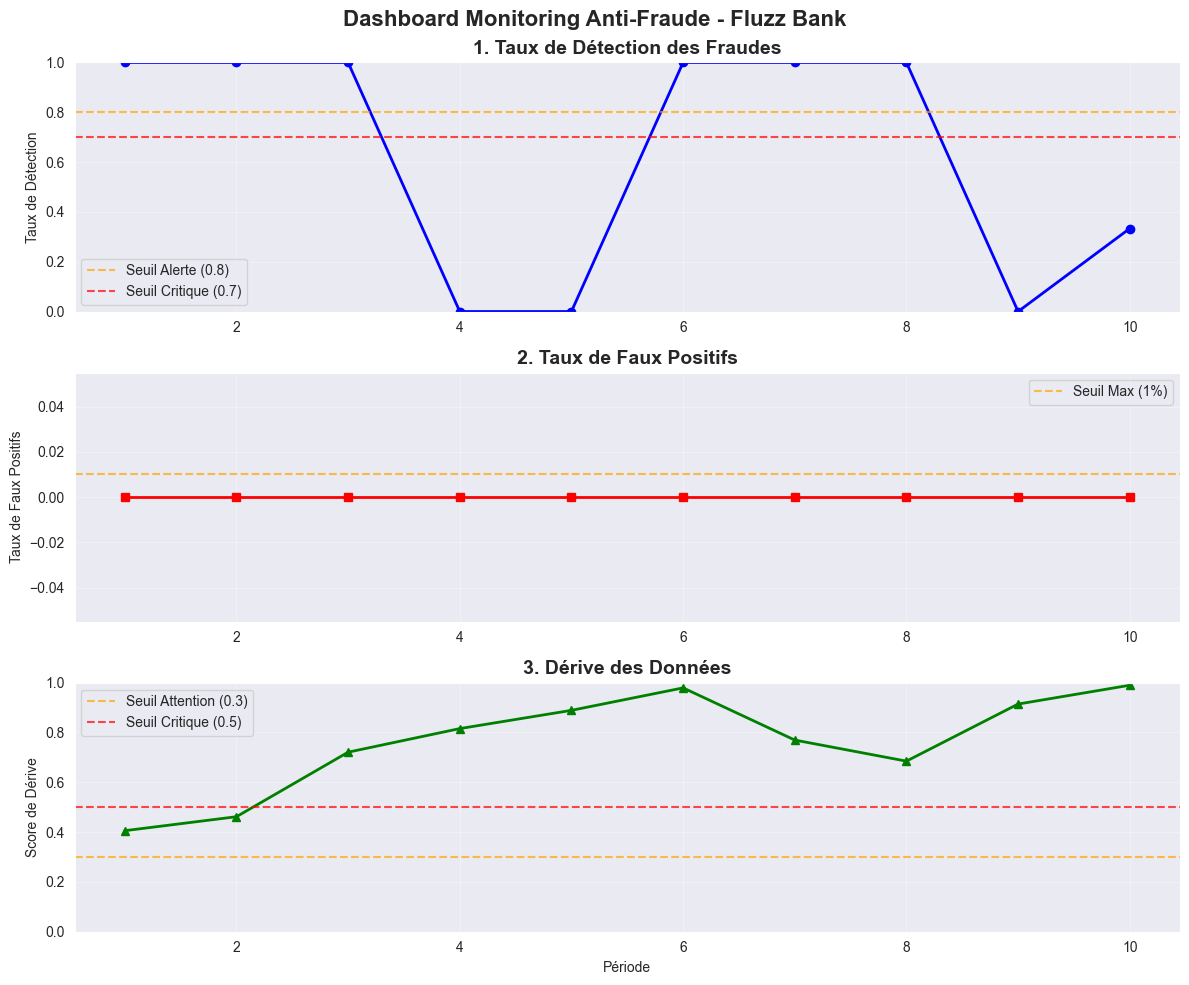


ÉTAT ACTUEL DU SYSTÈME:
   Taux de détection: 33.3%
   Taux faux positifs: 0.00%
   Score de dérive: 0.990

STATUT: CRITIQUE


In [17]:
# Dashboard simple avec les 3 métriques demandées
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 1. Taux de détection
axes[0].plot(monitoring_data['period'], monitoring_data['detection_rate'], 
             'b-', linewidth=2, marker='o', markersize=6)
axes[0].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Seuil Alerte (0.8)')
axes[0].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Seuil Critique (0.7)')
axes[0].set_title('1. Taux de Détection des Fraudes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Taux de Détection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# 2. Taux de faux positifs
axes[1].plot(monitoring_data['period'], monitoring_data['false_positive_rate'], 
             'r-', linewidth=2, marker='s', markersize=6)
axes[1].axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='Seuil Max (1%)')
axes[1].set_title('2. Taux de Faux Positifs', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Taux de Faux Positifs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Dérive des données
axes[2].plot(monitoring_data['period'], monitoring_data['data_drift_score'], 
             'g-', linewidth=2, marker='^', markersize=6)
axes[2].axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='Seuil Attention (0.3)')
axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Seuil Critique (0.5)')
axes[2].set_title('3. Dérive des Données', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Score de Dérive')
axes[2].set_xlabel('Période')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 1)

plt.suptitle('Dashboard Monitoring Anti-Fraude - Fluzz Bank', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Résumé des métriques actuelles
latest = monitoring_data.iloc[-1]
print("\nÉTAT ACTUEL DU SYSTÈME:")
print(f"   Taux de détection: {latest['detection_rate']:.1%}")
print(f"   Taux faux positifs: {latest['false_positive_rate']:.2%}")
print(f"   Score de dérive: {latest['data_drift_score']:.3f}")

# Status global
if latest['detection_rate'] < 0.7 or latest['data_drift_score'] > 0.5:
    status = "CRITIQUE"
elif latest['detection_rate'] < 0.8 or latest['data_drift_score'] > 0.3:
    status = "ATTENTION"
else:
    status = "NOMINAL"
    
print(f"\nSTATUT: {status}")

## 5. Système d'alertes automatiques simple

In [18]:
def check_alerts(data):
    """Vérifie les seuils d'alerte et génère les alertes"""
    alerts = []
    
    detection_rate = data['detection_rate']
    fp_rate = data['false_positive_rate']
    drift_score = data['data_drift_score']
    
    # Alertes pour taux de détection
    if detection_rate < 0.7:
        alerts.append({
            'type': 'CRITIQUE',
            'message': f'Taux de détection critique: {detection_rate:.1%}',
            'metric': 'detection_rate',
            'value': detection_rate
        })
    elif detection_rate < 0.8:
        alerts.append({
            'type': 'ATTENTION',
            'message': f'Taux de détection faible: {detection_rate:.1%}',
            'metric': 'detection_rate',
            'value': detection_rate
        })
    
    # Alertes pour faux positifs
    if fp_rate > 0.02:  # >2%
        alerts.append({
            'type': 'CRITIQUE',
            'message': f'Taux de faux positifs élevé: {fp_rate:.2%}',
            'metric': 'false_positive_rate',
            'value': fp_rate
        })
    elif fp_rate > 0.01:  # >1%
        alerts.append({
            'type': 'ATTENTION',
            'message': f'Taux de faux positifs élevé: {fp_rate:.2%}',
            'metric': 'false_positive_rate',
            'value': fp_rate
        })
    
    # Alertes pour dérive
    if drift_score > 0.5:
        alerts.append({
            'type': 'CRITIQUE',
            'message': f'Dérive critique détectée: {drift_score:.3f}',
            'metric': 'data_drift_score',
            'value': drift_score,
            'action': 'Réentraînement du modèle requis'
        })
    elif drift_score > 0.3:
        alerts.append({
            'type': 'ATTENTION',
            'message': f'Dérive détectée: {drift_score:.3f}',
            'metric': 'data_drift_score',
            'value': drift_score,
            'action': 'Surveillance renforcée'
        })
    
    return alerts

# Vérification des alertes sur toutes les périodes
all_alerts = []
for idx, row in monitoring_data.iterrows():
    period_alerts = check_alerts(row)
    for alert in period_alerts:
        alert['period'] = row['period']
        alert['timestamp'] = row['timestamp']
    all_alerts.extend(period_alerts)

print(f"ALERTES DÉTECTÉES: {len(all_alerts)}")

if all_alerts:
    # Tri par criticité
    critiques = [a for a in all_alerts if a['type'] == 'CRITIQUE']
    attentions = [a for a in all_alerts if a['type'] == 'ATTENTION']
    
    print(f"   Critiques: {len(critiques)}")
    print(f"   Attention: {len(attentions)}")
    
    print(f"\nALERTES PRINCIPALES:")
    for alert in all_alerts[-5:]:  # 5 dernières
        print(f"   Période {alert['period']}: {alert['message']}")
        if 'action' in alert:
            print(f"      → {alert['action']}")
else:
    print("   Aucune alerte générée")

print(f"\nCONFIGURATION ALERTES:")
print(f"   Détection < 80%: Attention | < 70%: Critique")
print(f"   Faux positifs > 1%: Attention | > 2%: Critique")
print(f"   Dérive > 0.3: Attention | > 0.5: Critique")

ALERTES DÉTECTÉES: 14
   Critiques: 12
   Attention: 2

ALERTES PRINCIPALES:
   Période 8: Dérive critique détectée: 0.685
      → Réentraînement du modèle requis
   Période 9: Taux de détection critique: 0.0%
   Période 9: Dérive critique détectée: 0.914
      → Réentraînement du modèle requis
   Période 10: Taux de détection critique: 33.3%
   Période 10: Dérive critique détectée: 0.990
      → Réentraînement du modèle requis

CONFIGURATION ALERTES:
   Détection < 80%: Attention | < 70%: Critique
   Faux positifs > 1%: Attention | > 2%: Critique
   Dérive > 0.3: Attention | > 0.5: Critique
